In [16]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from transformers import ViTForImageClassification, ViTImageProcessor

#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cpu


In [17]:
#Dataset Class
class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, processor, split='train', max_samples=None):
        self.image_dir = image_dir
        self.processor = processor
        self.split = split
        
        # Build file paths and labels
        self.image_paths = []
        self.labels = []
        
        split_dir = os.path.join(image_dir, split)
        if not os.path.exists(split_dir):
            raise FileNotFoundError(f"Directory {split_dir} not found")
        
        classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        
        print(f"Found classes: {classes}")
        print(f"Class mapping: {self.class_to_idx}")
        
        for class_name in classes:
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.exists(class_dir):
                continue
                
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Limit samples if specified
            if max_samples:
                samples_per_class = max_samples // len(classes)
                image_files = image_files[:samples_per_class]
            
            for img_name in image_files:
                img_path = os.path.join(class_dir, img_name)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        print(f"Loaded {len(self.image_paths)} images for {split} split")
        if len(self.labels) > 0:
            print(f"Class distribution: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('RGB')
            
            # Process the image using ViT processor
            inputs = self.processor(images=image, return_tensors="pt")
            pixel_values = inputs.pixel_values.squeeze(0)  # Remove batch dimension
            
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return pixel_values, label
            
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return a dummy tensor and label
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, torch.tensor(0, dtype=torch.long)

In [ ]:
def plot_sample_images(dataset, class_names, num_samples=8):
    """Plot sample images from the dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get random samples
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    for i, idx in enumerate(indices):
        if i >= num_samples:
            break
            
        image_path = dataset.image_paths[idx]
        label = dataset.labels[idx]
        
        # Load and display image
        image = Image.open(image_path).convert('RGB')
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Class: {class_names[label]}')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(indices), num_samples):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_distribution(datasets, dataset_names, class_names):
    """Plot class distribution across datasets"""
    fig, axes = plt.subplots(1, len(datasets), figsize=(5*len(datasets), 4))
    if len(datasets) == 1:
        axes = [axes]
    
    for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
        if len(dataset.labels) > 0:
            class_counts = np.bincount(dataset.labels)
            axes[i].bar(class_names, class_counts, alpha=0.7)
            axes[i].set_title(f'{name} Set Distribution')
            axes[i].set_ylabel('Number of Images')
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add count labels on bars
            for j, count in enumerate(class_counts):
                axes[i].text(j, count + max(class_counts)*0.01, str(count), 
                           ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=10):
    """Enhanced training function with better monitoring"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    best_val_acc = 0
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, labels) in enumerate(train_pbar):
            try:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(pixel_values=images)
                loss = criterion(outputs.logits, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
                
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                train_preds.extend(preds)
                train_labels.extend(labels.cpu().numpy())
                
                train_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Batch': f'{batch_idx+1}/{len(train_loader)}'
                })
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue
        
        train_acc = accuracy_score(train_labels, train_preds) if train_labels else 0
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
        
        # Validation phase
        model.eval()
        val_preds = []
        val_labels = []
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_pbar):
                try:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(pixel_values=images)
                    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    val_preds.extend(preds)
                    val_labels.extend(labels.cpu().numpy())
                    
                    val_pbar.set_postfix({
                        'Batch': f'{batch_idx+1}/{len(val_loader)}'
                    })
                    
                except Exception as e:
                    print(f"Error in validation batch {batch_idx}: {e}")
                    continue
        
        val_acc = accuracy_score(val_labels, val_preds) if val_labels else 0
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        learning_rates.append(current_lr)
        
        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}')
        print('-' * 60)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
            }, 'best_vit_model.pth')
            print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    return train_losses, train_accuracies, val_accuracies, learning_rates, best_val_acc

def evaluate_model(model, test_loader, device, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            try:
                images, labels = images.to(device), labels.to(device)
                outputs = model(pixel_values=images)
                
                probs = F.softmax(outputs.logits, dim=1)
                preds = torch.argmax(outputs.logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
            except Exception as e:
                print(f"Error in evaluation: {e}")
                continue
    
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return all_labels, all_preds, all_probs, cm, report

In [ ]:
def plot_comprehensive_results(train_losses, train_accuracies, val_accuracies, learning_rates, 
                             cm, class_names, all_labels, all_preds, all_probs):
    """Comprehensive plotting function"""
    fig = plt.figure(figsize=(20, 16))
    
    # Training loss
    plt.subplot(3, 3, 1)
    plt.plot(train_losses, marker='o', linewidth=2)
    plt.title('Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Training and validation accuracy
    plt.subplot(3, 3, 2)
    epochs = range(1, len(train_accuracies) + 1)
    plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', linewidth=2)
    plt.plot(epochs, val_accuracies, marker='s', label='Val Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    plt.subplot(3, 3, 3)
    plt.plot(learning_rates, marker='o', linewidth=2)
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # Confusion matrix
    plt.subplot(3, 3, 4)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Normalized confusion matrix
    plt.subplot(3, 3, 5)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Class-wise accuracy
    plt.subplot(3, 3, 6)
    class_accuracies = []
    for i, class_name in enumerate(class_names):
        class_mask = np.array(all_labels) == i
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(np.array(all_labels)[class_mask], 
                                     np.array(all_preds)[class_mask])
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)
    
    bars = plt.bar(class_names, class_accuracies, alpha=0.7, color=['skyblue', 'lightcoral'])
    plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Prediction confidence distribution
    plt.subplot(3, 3, 7)
    if len(all_probs) > 0:
        max_probs = np.max(all_probs, axis=1)
        plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Max Probability')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(max_probs), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(max_probs):.3f}')
        plt.legend()
    
    # ROC curve for binary classification
    if len(class_names) == 2 and len(all_probs) > 0:
        plt.subplot(3, 3, 8)
        from sklearn.metrics import roc_curve, auc
        
        y_true_binary = np.array(all_labels)
        y_score = np.array(all_probs)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Training summary
    plt.subplot(3, 3, 9)
    plt.axis('off')
    summary_text = f"""
    Training Summary:
    
    Final Train Accuracy: {train_accuracies[-1]:.4f}
    Final Val Accuracy: {val_accuracies[-1]:.4f}
    Best Val Accuracy: {max(val_accuracies):.4f}
    
    Final Learning Rate: {learning_rates[-1]:.2e}
    Total Epochs: {len(train_accuracies)}
    
    Test Samples: {len(all_labels)}
    Classes: {len(class_names)}
    """
    plt.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout(pad=3.0)
    plt.savefig('comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Initialize ViT model and processor
model_name = "google/vit-base-patch16-224"
print(f"Loading ViT model: {model_name}")

processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name, 
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Move model to device
model = model.to(device)
print(f"Model moved to {device}")

Loading ViT model: google/vit-base-patch16-224


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cpu


In [ ]:
# Dataset configuration
data_dir = "chest_Xray"
batch_size = 8

# Create datasets
print("Loading datasets...")
train_dataset = ChestXrayDataset(data_dir, processor, split='train', max_samples=1000)
val_dataset = ChestXrayDataset(data_dir, processor, split='val', max_samples=200)

# Handle missing test set
try:
    test_dataset = ChestXrayDataset(data_dir, processor, split='test', max_samples=200)
except FileNotFoundError:
    print("No test set found, using validation set for testing")
    test_dataset = val_dataset

# Get class names
class_names = list(train_dataset.idx_to_class.values())
print(f"Classes: {class_names}")

Loading datasets...
Found classes: ['NORMAL', 'PNEUMONIA']
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Loaded 1000 images for train split
Class distribution: [500 500]
Found classes: ['NORMAL', 'PNEUMONIA']
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Loaded 16 images for val split
Class distribution: [8 8]
Found classes: ['NORMAL', 'PNEUMONIA']
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Loaded 200 images for test split
Class distribution: [100 100]
Classes: ['NORMAL', 'PNEUMONIA']


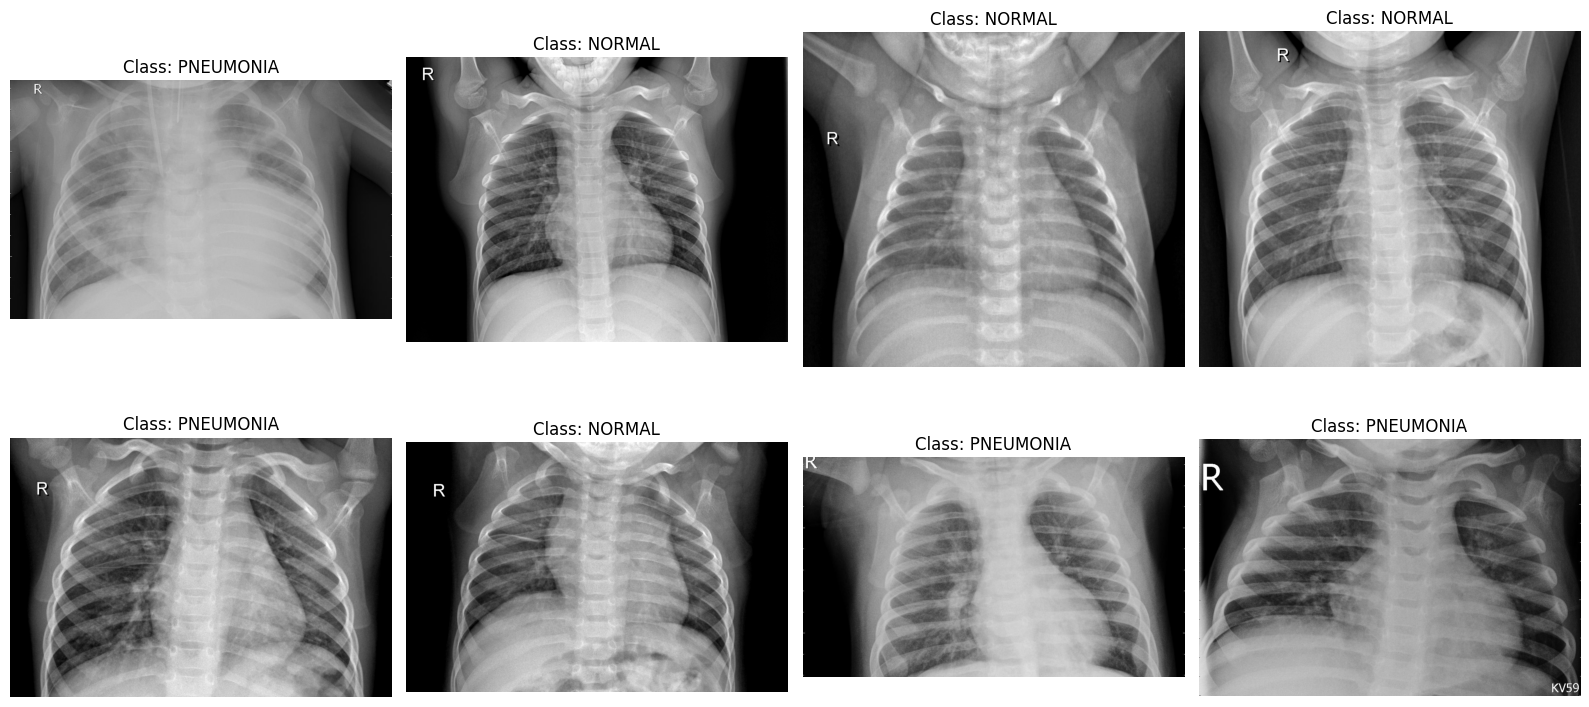

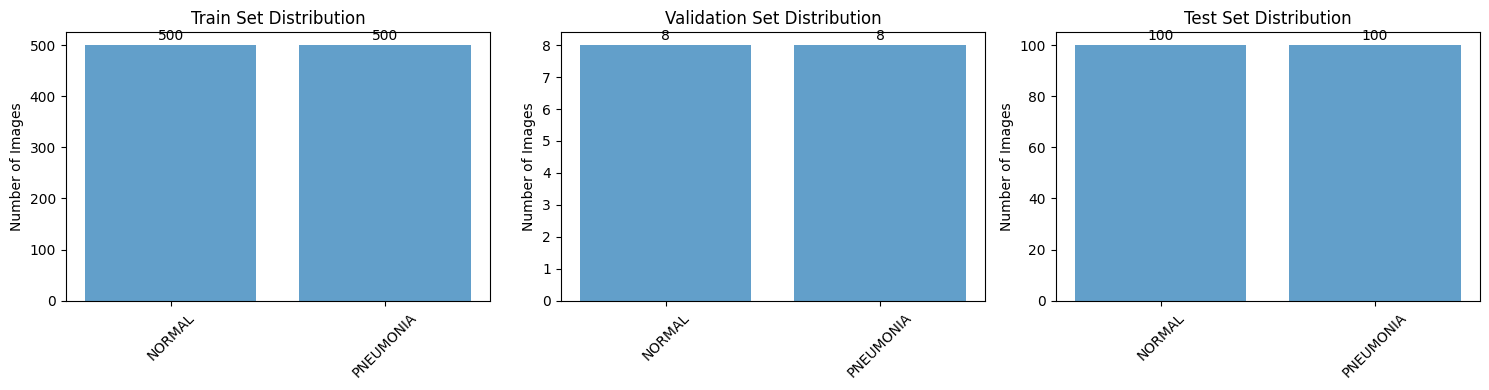

In [ ]:
# Plot dataset overview
plot_sample_images(train_dataset, class_names)
plot_class_distribution([train_dataset, val_dataset, test_dataset], 
                      ['Train', 'Validation', 'Test'], class_names)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                      num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=0, pin_memory=True)

print(f"Data loaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

Data loaders created:
  Train: 125 batches
  Val: 2 batches
  Test: 25 batches


In [25]:
# Train the model
print("Starting training...")
train_losses, train_accuracies, val_accuracies, learning_rates, best_val_acc = train_model(
    model, train_loader, val_loader, device, num_epochs=5
)

# Cell 11: Load Best Model and Evaluate
# Load best model for evaluation
print("Loading best model for evaluation...")
checkpoint = torch.load('best_vit_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
print("Evaluating on test set...")
test_labels, test_preds, test_probs, cm, report = evaluate_model(
    model, test_loader, device, class_names)

Starting training...


Epoch 1/5 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/5 [Val]: 100%|██████████| 2/2 [00:08<00:00,  4.14s/it, Batch=2/2]



Epoch 1/5 Summary:
Train Loss: 0.1932, Train Acc: 0.9160
Val Acc: 0.6250, LR: 0.000020
------------------------------------------------------------
New best model saved with validation accuracy: 0.6250


Epoch 2/5 [Train]:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 2/5 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 2/5 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.66s/it, Batch=2/2]



Epoch 2/5 Summary:
Train Loss: 0.0278, Train Acc: 0.9920
Val Acc: 0.9375, LR: 0.000020
------------------------------------------------------------
New best model saved with validation accuracy: 0.9375


Epoch 3/5 [Train]:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 3/5 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 3/5 [Val]: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it, Batch=2/2]



Epoch 3/5 Summary:
Train Loss: 0.0297, Train Acc: 0.9900
Val Acc: 0.6250, LR: 0.000002
------------------------------------------------------------


Epoch 4/5 [Train]:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 4/5 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 4/5 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it, Batch=2/2]



Epoch 4/5 Summary:
Train Loss: 0.0005, Train Acc: 1.0000
Val Acc: 0.6250, LR: 0.000002
------------------------------------------------------------


Epoch 5/5 [Train]:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 5/5 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 5/5 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.58s/it, Batch=2/2]



Epoch 5/5 Summary:
Train Loss: 0.0002, Train Acc: 1.0000
Val Acc: 0.6250, LR: 0.000002
------------------------------------------------------------
Loading best model for evaluation...
Evaluating on test set...


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


Test Accuracy: 0.8900

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.79      0.88       100
   PNEUMONIA       0.82      0.99      0.90       100

    accuracy                           0.89       200
   macro avg       0.91      0.89      0.89       200
weighted avg       0.91      0.89      0.89       200



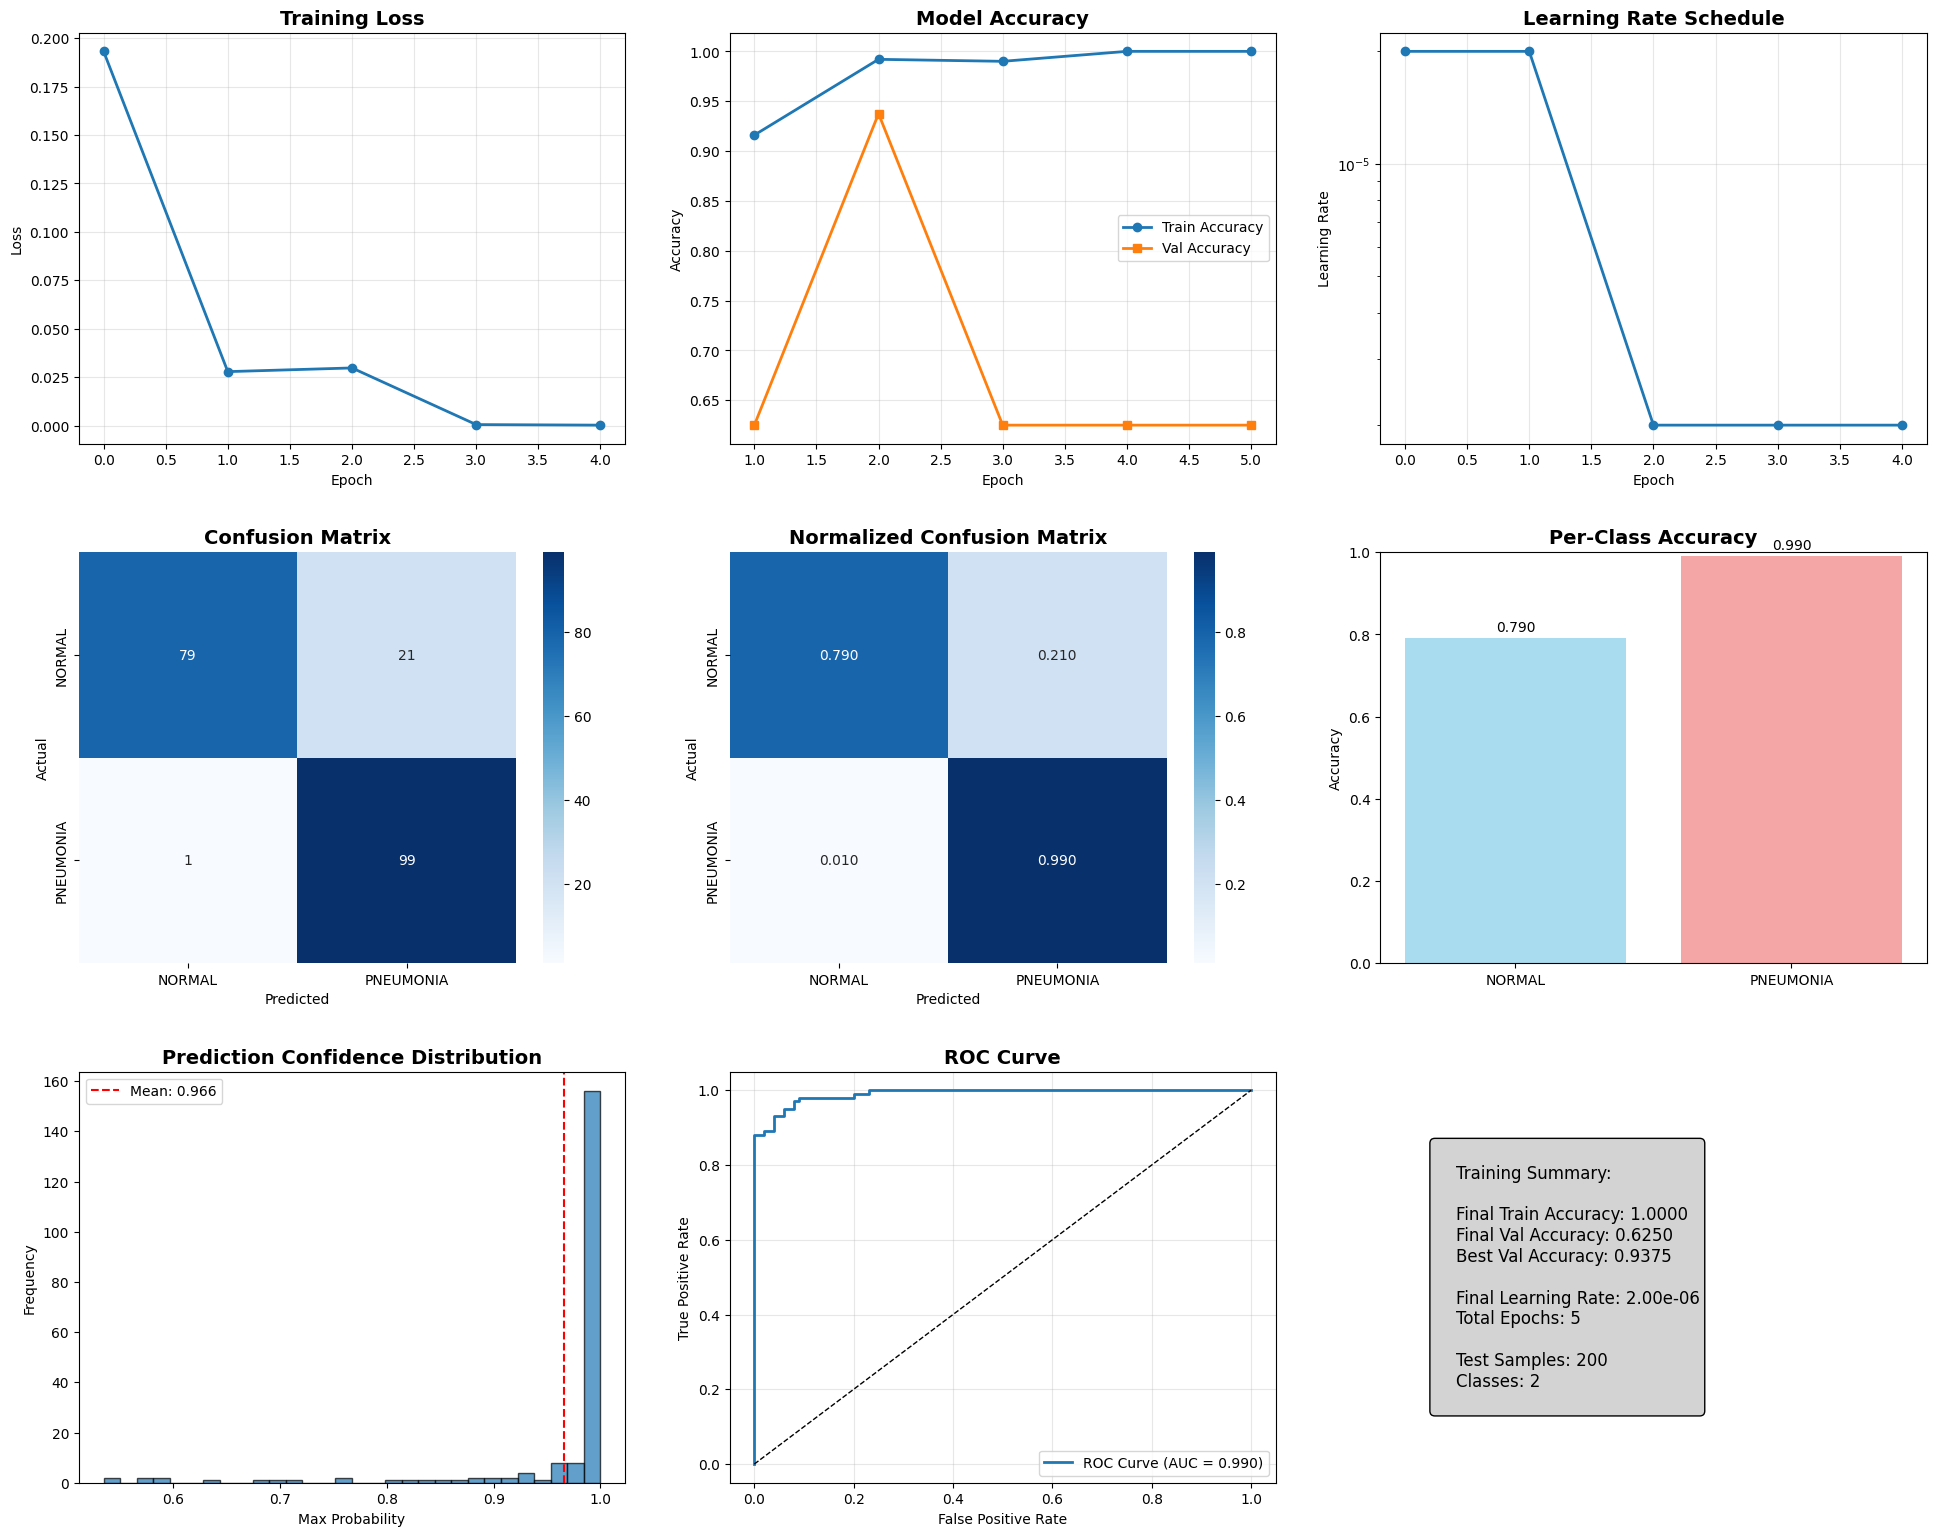


Training completed!
Best validation accuracy: 0.9375
Results saved to training_results.npy


In [ ]:
# Plot comprehensive results
plot_comprehensive_results(train_losses, train_accuracies, val_accuracies, 
                         learning_rates, cm, class_names, 
                         test_labels, test_preds, test_probs)

print(f"\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Save final results
results = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'learning_rates': learning_rates,
    'best_val_acc': best_val_acc,
    'test_accuracy': accuracy_score(test_labels, test_preds),
    'classification_report': report
}

np.save('results_vit/training_results.npy', results)
print("Results saved to training_results.npy")

In [ ]:
os.makedirs("results_vit", exist_ok=True)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.reset_index().rename(columns={'index': 'class'})

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df = cm_df.reset_index().rename(columns={'index': 'actual'})

# Save classification report
report_path = os.path.join("results_vit", "classification_report.parquet")
report_df.to_parquet(report_path)

# Save confusion matrix
cm_path = os.path.join("results_vit", "confusion_matrix.parquet")
cm_df.to_parquet(cm_path)

print(f"Classification report saved to: {report_path}")
print(f"Confusion matrix saved to: {cm_path}")

Classification report saved to: results_vit\classification_report.parquet
Confusion matrix saved to: results_vit\confusion_matrix.parquet
